In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Part 1 - Exploratory Data Analysis

In [2]:
logins_data_df = pd.read_json('../logins.json')
logins_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
logins_data_df.set_index('login_time', inplace=True)
logins_data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Empty DataFrame

In [4]:
logins_data_df['count_login'] = 1
#logins_data_df.head()
#logins_data_df.resample('15min').sum()

<Figure size 1080x1080 with 0 Axes>

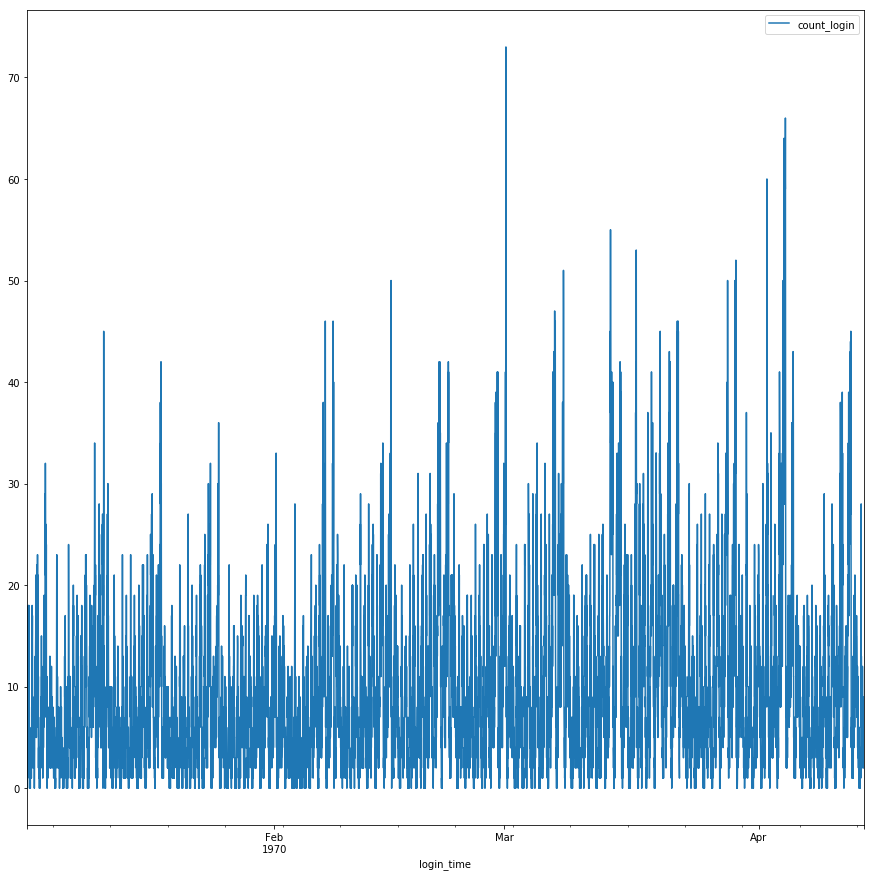

In [5]:

plt.figure(figsize=(15,15))
logins_data_df.resample('15min').sum().plot(figsize=(15,15))

plt.savefig('login_resampled.png')
plt.show()

 ### Discussion

Demand is cyclic and peaks on the weekend.

Also, the first data starts on 01 Jan 1970, which is incidently the epoch time for all linux systems. It may be possible that the server that records the logins may not have set its current time correctly.

## Part 2 - Experiment and metrics design

Randomly create two driver partner groups
* Control group - pay toll 
* Promotion group - get reimbursed for toll

Let's define metric of interest = proportion of drivers serving both cities
Evaluate metric for control and promoted group

If a significant (statistically and practically) higher proportion of promoted group serves both cities then the promotion is effective.

The experiment could be conducted multiple times by changing the random allocation.

## Part 3 ‑ Predictive modeling

In [6]:
with open('../ultimate_data_challenge.json') as json_file:
    ultimate_data = json.load(json_file)

In [7]:
ultimate_data_df = json_normalize(ultimate_data)
ultimate_data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [8]:
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [9]:
ultimate_data_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [10]:
ultimate_data_df['last_trip_date'].describe()

count          50000
unique           182
top       2014-06-29
freq            2036
Name: last_trip_date, dtype: object

### Compute whether a user is active

In [11]:
ultimate_data_df['active'] = pd.DatetimeIndex(ultimate_data_df['last_trip_date']).month == 6

ultimate_data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


### Data cleaning
Since there are many (16%) missing values for avg_rating_of_driver and its not clear whether the rating was just not given or not recorded. We cannot throw away the large amount of data due to these missing values. Therefore, we choose to fill it with mean value.

We also fill the missing values for avg_rating_by_driver with mean value and for phone with most frequent value.

In [12]:
nan_index = ultimate_data_df['avg_rating_by_driver'].isna()

ultimate_data_df[nan_index]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
90,6.28,NaN,5.0,1.00,Winterfell,2014-02-09,iPhone,2014-01-10,0.0,1,False,0.0,False
274,6.00,NaN,2.0,4.00,Astapor,2014-02-09,iPhone,2014-01-25,100.0,1,False,0.0,False
277,1.82,NaN,NaN,1.00,Winterfell,2014-01-26,iPhone,2014-01-25,0.0,1,False,0.0,False
536,1.41,NaN,5.0,1.00,Winterfell,2014-02-08,Android,2014-01-18,0.0,1,False,100.0,False
857,0.42,NaN,4.0,1.00,Winterfell,2014-03-16,iPhone,2014-01-11,0.0,0,False,0.0,False
1021,2.33,NaN,NaN,1.75,King's Landing,2014-06-13,iPhone,2014-01-23,100.0,0,True,100.0,True
1073,9.21,NaN,5.0,1.00,King's Landing,2014-04-27,Android,2014-01-19,0.0,0,False,0.0,False
1164,2.57,NaN,2.0,1.00,Winterfell,2014-01-25,Android,2014-01-24,0.0,1,True,100.0,False
1181,24.91,NaN,3.0,1.00,Winterfell,2014-01-25,Android,2014-01-25,0.0,1,False,0.0,False
1205,8.94,NaN,NaN,1.00,Winterfell,2014-02-22,Android,2014-01-18,0.0,0,False,100.0,False


In [13]:
nan_index = ultimate_data_df['phone'].isna()

ultimate_data_df[nan_index]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
134,2.88,5.0,5.0,1.00,King's Landing,2014-06-11,None,2014-01-10,0.0,0,False,100.0,True
176,20.32,5.0,5.0,1.00,Astapor,2014-03-18,None,2014-01-28,0.0,0,False,100.0,False
320,31.01,5.0,5.0,1.00,Astapor,2014-01-09,None,2014-01-08,0.0,1,False,100.0,False
349,6.03,5.0,3.3,1.00,Winterfell,2014-06-22,None,2014-01-06,0.0,1,True,33.3,True
389,3.08,4.8,4.9,1.02,King's Landing,2014-07-01,None,2014-01-26,3.0,5,False,66.7,False
434,5.09,4.4,4.8,1.13,King's Landing,2014-06-25,None,2014-01-23,14.3,3,False,85.7,True
494,2.59,4.9,5.0,1.03,Astapor,2014-06-10,None,2014-01-24,10.5,1,False,94.7,True
532,7.21,4.5,5.0,1.06,King's Landing,2014-06-27,None,2014-01-11,7.7,0,True,51.3,True
534,129.89,5.0,NaN,1.00,King's Landing,2014-03-09,None,2014-01-04,0.0,0,False,0.0,False
611,3.01,3.5,5.0,1.04,Astapor,2014-03-01,None,2014-01-17,16.7,5,False,83.3,False


In [14]:
ultimate_data_df.groupby(['phone']).count()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
phone,,,,,,,,,,,,
Android,15022,14960,12134,15022,15022,15022,15022,15022,15022,15022,15022,15022
iPhone,34582,34446,29444,34582,34582,34582,34582,34582,34582,34582,34582,34582


In [15]:
ultimate_data_filled_df = ultimate_data_df

ultimate_data_filled_df = ultimate_data_filled_df.fillna(value ={'avg_rating_of_driver':  4.601559, 'avg_rating_by_driver': 4.778158, 'phone': 'iPhone'} )

ultimate_data_filled_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


In [16]:
ultimate_data_filled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null bool
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 4.3+ MB


## Fraction of users retained

In [17]:
number_active = ultimate_data_df.active.sum()
print('number_active', number_active)

fraction_active = number_active/50000
print('fraction_active', fraction_active)

number_active 18256
fraction_active 0.36512


Perform one hot encoding for categorical features

In [18]:
ultimate_data_filled_df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

### Feature engineering

In [19]:

ultimate_data_filled_df['todays_date'] = pd.to_datetime('30 June 2014')

last_trip_date_dt = pd.to_datetime(ultimate_data_filled_df.last_trip_date)

ultimate_data_filled_df['days_since_last_trip'] = (ultimate_data_filled_df['todays_date'] - last_trip_date_dt).dt.days
#ultimate_data_filled_df['days_since_last_trip'] = ultimate_data_filled_df['days_since_last_trip'].days

last_trip_date_dt = pd.to_datetime(ultimate_data_filled_df.last_trip_date).dt

ultimate_data_filled_df['last_trip_dayofweek'] = last_trip_date_dt.dayofweek

In [20]:


signup_date_dt = pd.to_datetime(ultimate_data_filled_df.signup_date)

ultimate_data_filled_df['days_since_signup'] = (ultimate_data_filled_df['todays_date'] - signup_date_dt).dt.days

signup_date_dt = pd.to_datetime(ultimate_data_filled_df.signup_date).dt

ultimate_data_filled_df['signup_date_dayofweek'] = signup_date_dt.dayofweek

In [21]:
label_enc = LabelEncoder()

In [22]:
city_labels = label_enc.fit_transform(ultimate_data_filled_df['city'])
phone_labels = label_enc.fit_transform(ultimate_data_filled_df['phone'])
ultimate_black_user_labels = label_enc.fit_transform(ultimate_data_filled_df['ultimate_black_user'])

enc = OneHotEncoder()


    
#city_ohe = enc.fit_transform()

In [23]:
label_matrix = np.stack((city_labels, phone_labels, ultimate_black_user_labels), axis = -1) #.reshape(50000, 3)
label_matrix

#np.atleast_1d

array([[1, 1, 1],
       [0, 0, 0],
       [0, 1, 0],
       ...,
       [2, 0, 1],
       [0, 1, 0],
       [0, 0, 0]], dtype=int64)

In [24]:
enc = OneHotEncoder(handle_unknown='error', sparse=False)

encoded_city_phone_ultimate_black_user = enc.fit_transform(label_matrix)
encoded_city_phone_ultimate_black_user.shape

C:\Users\iamga\Miniconda2\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(50000, 7)

### Predictive Modeling

In [25]:

# columns_used = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 
#                 'weekday_pct', 'days_since_last_trip', 'last_trip_dayofweek', 'days_since_signup', 'signup_date_dayofweek']

columns_used = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 
                'weekday_pct', 'last_trip_dayofweek', 'days_since_signup', 'signup_date_dayofweek']

X = np.column_stack((  ultimate_data_filled_df[columns_used], encoded_city_phone_ultimate_black_user))

y = ultimate_data_filled_df['active']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


logistic_clf = LogisticRegression(random_state=0, solver='lbfgs')
logistic_clf.fit(X_train, y_train)

print('Prediction on training data: ', logistic_clf.score(X_train, y_train))

print('Prediction on test data: ', logistic_clf.score(X_test, y_test))


Prediction on training data:  0.714975
Prediction on test data:  0.7126


C:\Users\iamga\Miniconda2\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [27]:
# print(logistic_clf.coef_, '\n')
# print(np.std(a=X, axis=0), '\n')

feature_importance = np.std(a=X, axis=0)*logistic_clf.coef_
# print(feature_importance)
feature_shape = feature_importance.shape

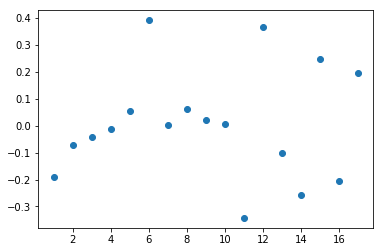

In [28]:
plt.plot(range(1,feature_shape[1]+1), feature_importance.T, 'o')
plt.show()

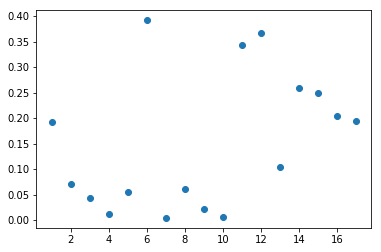

In [29]:
plt.plot(range(1,feature_shape[1]+1), np.abs(feature_importance).T, 'o')
plt.show()


The most important feature is the number of trips the user took in the first 30 days. Ultimate Inc., should try to find ways such that the user can experience their service as much as possible in the first 30 days. This could be done via a free trial period or other promostions.